Cluster molecules and visualize SAR based on simple molecular descriptors.

Structure/activity data drawn from "A High Throughput Confirmatory Assay used to Identify Novel Compounds that Inhibit Mycobacterium Tuberculosis in the absence of Glycerol" (PubChem AID 449764).
https://pubchem.ncbi.nlm.nih.gov/bioassay/449764

Molecular descriptors calculated with KNIME-CDK version 1.5.600.v201711101057.

In [1]:
## setup cell
# import required libaries
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
## load and process data
# load the initial dataset
screening_data = pd.read_csv("descriptors.csv")

# convert SMILES strings into RDKit format
screening_data["mol"] = screening_data["SMILES"].apply(Chem.MolFromSmiles)

# calculate Morgan fingerprints for the molecules
screening_data["fingerprints"] = screening_data["mol"].apply(lambda x: GetMorganFingerprintAsBitVect(x, 2))

In [3]:
## calculate Tanimoto distance matrix between molecular fingerprints
# declare an array to hold the distances
distances = np.empty([len(screening_data["fingerprints"]), len(screening_data["fingerprints"])])

# calculate the distance array
for i in range(len(screening_data["fingerprints"])):
    for j in range(i, len(screening_data["fingerprints"])):
        distances[i, j] = 1 - DataStructs.TanimotoSimilarity(screening_data["fingerprints"][i], screening_data["fingerprints"][j])
        distances[j, i] = distances[i, j]

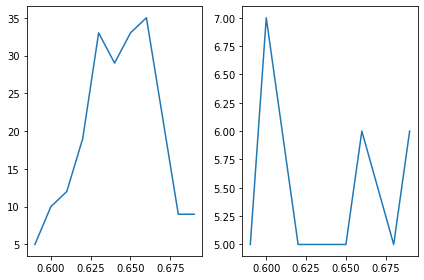

In [4]:
## tune clustering algorithm
# select some values of epsilon to try
epsilon = np.arange(0.59, 0.7, 0.01)

# declare an empty array to hold the number of clusters
n_clusters = np.empty([len(epsilon), 2])

# scan through epsilon values
for i in range(len(epsilon)):
    # cluster by distance at each epsilon
    clusters = DBSCAN(eps = epsilon[i], min_samples = 5, metric = "precomputed").fit(distances)
    
    # store the number of clusters generated and median cluster size
    # number of clusters (including singletons as a class)
    n_clusters[i, 0] = len(np.unique(clusters.labels_))
    # median cluster size
    n_clusters[i, 1] = np.median(pd.Series(clusters.labels_).value_counts())
    
# plot number of clusters as a function of epsilon
fig, axs = plt.subplots(1, 2, tight_layout = True)
axs[0].plot(epsilon, n_clusters[:, 0])
axs[1].plot(epsilon, n_clusters[:, 1])
plt.show()

In [5]:
# cluster compounds to give a balance between number of clusters and cluster size; store in dataframe
screening_data["cluster"] = DBSCAN(eps = 0.61, min_samples = 5, metric = "precomputed").fit(distances).labels_

# count the number of compounds per cluster
screening_data.cluster.value_counts()

-1     2181
 3       14
 5       12
 4       10
 2        9
 1        7
 9        5
 7        5
 10       5
 6        5
 0        5
 8        4
Name: cluster, dtype: int64

We have a large number of singletons in the dataset, but we have identified 11 clusters of reasonable size. The next step will be to evaluate the clustered compounds, plus look for singletons with particularly interesting chemical properties.

In [6]:
screening_data.groupby("cluster")["IC90"].mean()

cluster
-1      47.707590
 0      42.942000
 1      52.710000
 2      69.705714
 3      33.471111
 4      33.673750
 5      46.784000
 6      59.632500
 7      40.226667
 8     100.000000
 9      15.410000
 10     71.450000
Name: IC90, dtype: float64